# MAGIC AI Workshop 01 Introduction to machine learning


In this lab, we will introduce the basics of machine learning in Python. We'll cover some data exploration, designing a machine learning workflow (including a cross-validation strategy and performance metric) and look at how to try different algorithms. We'll also look briefly at making predictions with our model and exploring the results of the model. We'll use **scikit-learn**, a widely used toolkit for machine learning in Python. This provides a standard interface managing a machine learning workflow, including setting up training and testing data, running different algorithms and evaluating the models. You'll also need the following packages: `numpy`, `pandas` and `matplotlib`. Make sure these are installed using your favorite package manager (pip or conda)

Before starting, we'll define some vocabulary for the process of ML model building:

- Outcome or label: the variable that we are interested in predicting. The equivalent to covariates in a regression model
- Features: the variables we will use to predict the outcome. Equivalent to covariates in regression models
- Training: the process of estimating model weights
- Loss function: a measure of how well the predicted outcome ($\hat{y}$) maps to the observed outcome ($y$)
- Performance metric: a measure of how well the model can predict for an *independent* dataset
- Model weights: one or more values that are used to map the features to the outcome. The value of these is learned during the training process
- Hyperparameters: algorithm-specific parameters that control the way that the algorithm learns or updates the weights

The data we will use contains daily counts of rented bicycles from the bicycle rental company Capital-Bikeshare in Washington D.C., along with weather and seasonal information. Our goal is to build a model to predict the count of bikes rented on any given day (the count is the outcome). Before starting the lab, you will need to set up a new folder for your working directory. Download the file *bike.csv* from the Google drive folder and move it to this folder. 

https://drive.google.com/drive/folders/1GMEY1fYEj1YMI__u3hU4y6agnrz3ekna?usp=drive_link

Let's start by importing the packages that we will need

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

/var/folders/ql/nw995vq50pq3dlrxhk7mm4_40000gq/T/ipykernel_94223/1156951978.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Data

We'll start by loading the data and carrying out some simple exploration. 

In [2]:
bike = pd.read_csv("../datafiles/bike.csv")
bike.shape

(731, 12)

In [3]:
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,count,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


Now, use the `describe()` method to get some basic summary statistics

In [4]:
bike.describe()

,yr,temp,hum,windspeed,count,days_since_2011
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2011.500684,15.283085,62.789406,12.762576,4504.348837,365.000000
std,0.500342,8.603397,14.242910,5.192357,1937.211452,211.165812
min,2011.000000,-5.220871,0.000000,1.500244,22.000000,0.000000
25%,2011.000000,7.842925,52.000000,9.041650,3152.000000,182.500000
50%,2012.000000,15.421651,62.666700,12.125325,4548.000000,365.000000
75%,2012.000000,22.804575,73.020850,15.625371,5956.000000,547.500000
max,2012.000000,32.498349,97.250000,34.000021,8714.000000,730.000000


We'll now make some plots to take a look at how the features relate to the count of rental bikes. First, let's plot the time series of daily rentals. This shows a couple of things: a clear seasonal cycle and a long-term trend across the two years:

<Axes: xlabel='days_since_2011', ylabel='count'>

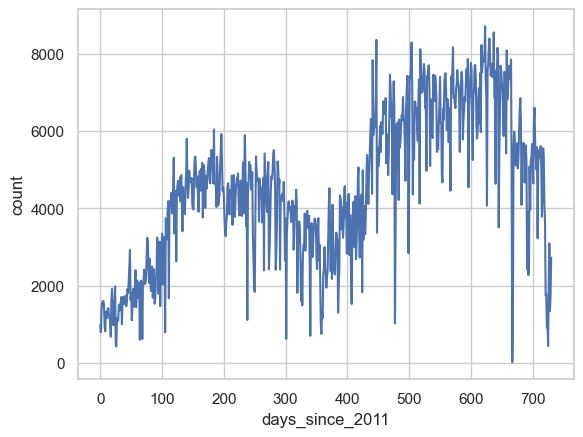

In [5]:
#plt.plot(bike['days_since_2011'], bike['count'])
sns.set_theme(style="whitegrid")
sns.lineplot(bike, x='days_since_2011', y='count')

We can also look at the distribution by day of the week, month, holiday, etc. 

<Axes: xlabel='weekday', ylabel='count'>

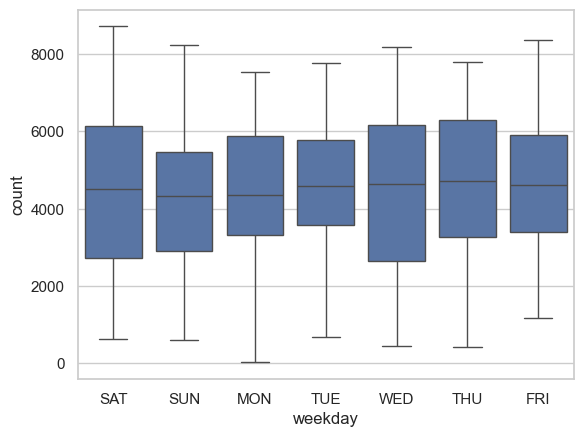

In [6]:
sns.boxplot(bike, x='weekday', y='count')

<Axes: xlabel='mnth', ylabel='count'>

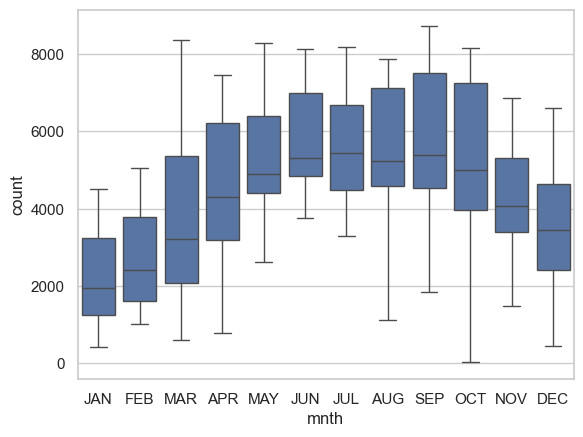

In [7]:
sns.boxplot(bike, x='mnth', y='count')

And by holiday

<Axes: xlabel='holiday', ylabel='count'>

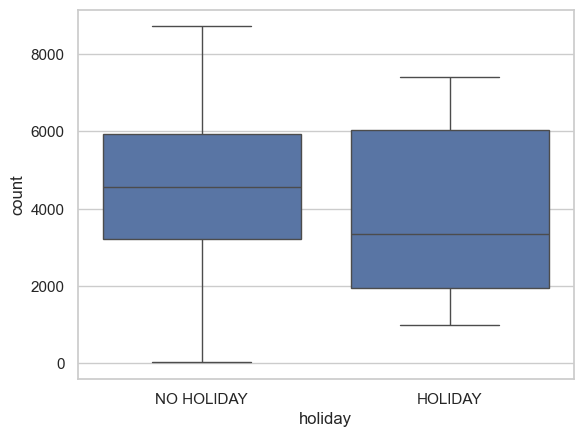

In [8]:
sns.boxplot(bike, x='holiday', y='count')

Again we can see the clear seasonal cycle, as well as a slightly higher rate on non-holdiays. There's little to no variation across week days however. We can also use some scatter plots to show the relationship of rentals to environmental features:

<Axes: xlabel='temp', ylabel='count'>

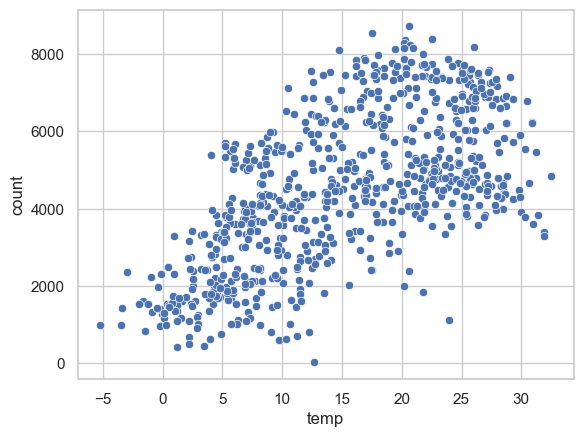

In [9]:
sns.scatterplot(bike, x='temp', y='count')

<Axes: xlabel='hum', ylabel='count'>

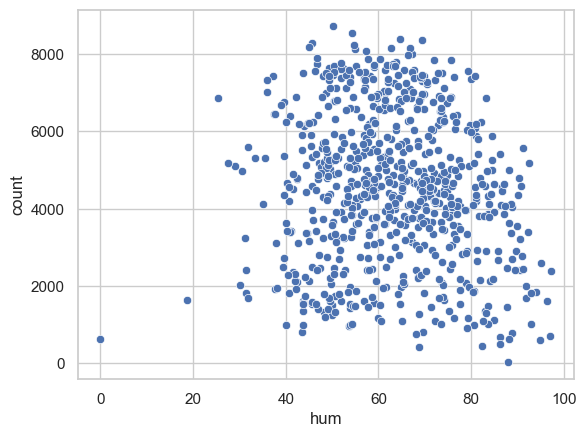

In [10]:
sns.scatterplot(bike, x='hum', y='count')

<Axes: xlabel='windspeed', ylabel='count'>

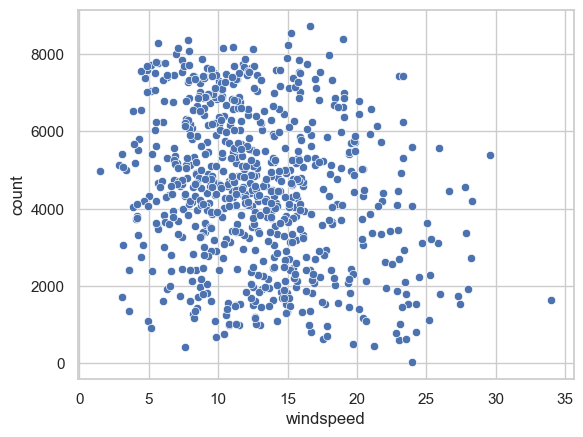

In [11]:
sns.scatterplot(bike, x='windspeed', y='count')

It's difficult to make out much in the humidity and windspeed plots, except that rentals appear to decline at higher values. Rentals generally increase with temperature, but appear to decline at higher temps. Most of this makes sense: cycling in high wind speed or hot, humid conditions is generally less appealing. The data also contain a more general 'weather type' categorical variable that we can use:

<Axes: xlabel='weathersit', ylabel='count'>

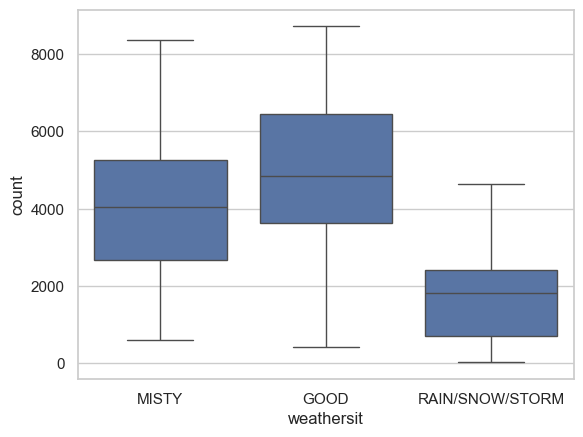

In [12]:
sns.boxplot(bike, x='weathersit', y='count')

## Machine learning


We'll now build a machine learning model with these data. We'll model the rental numbers using the environmental data, months and holiday/non-holiday variables. **scikit-learn** has a standardized API for running most algorithms, and the steps we are going to take here are largely the same for any of the approaches we might use:

- Form a data set of features (or covariates)
- Form a data set of labels (or responses)
- Split into a *training* and *testing* dataset
- Build or train a model with the training features and labels
- Predict using the testing features
- Compare the predicted test labels to the observed test labels
- Calculate a score indicating the model performance

### Preprocessing
Prior to building a model, we will want to clean the data to help optimize the training process and the predictive skill of the model. Some things to check for are:

- Outliers in the outcome variable
- Missing values
- High correlations between features

This dataset has already been cleaned so there is relatively little to do in processing it before building models. However, the plots above showed an observation with a relative humidity value of 0, which is likely an error, so we'll now remove these:

In [13]:
bike2 = bike[bike['hum']>0]

The standard approach to scikit learn is to divide the data into two new arrays `X`, containing the features and `y` containing the labels. We'll do this here by first choosing the features we want, then selecting these out into a new DataFrame

In [14]:
sel_features = ['temp', 'hum', 'windspeed', 'mnth', 'holiday', 'weathersit']
X = bike2[sel_features]

Next, we need to convert our categorical features to dummy variables (also called one-hot encoding). This converts them from their original values (e.g. JAN/FEB/MAR) to a set of binary features - one per class. For example, with the monthly data, we'll create 12 new features, one per month. The one for January will have 1's for all Jan observations and 0's for all other months, etc. To illustrate, let's run this just with the monthly column:

In [15]:
pd.get_dummies(X['mnth'], dtype=int)

,APR,AUG,DEC,FEB,JAN,JUL,JUN,MAR,MAY,NOV,OCT,SEP
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
726,0,0,1,0,0,0,0,0,0,0,0,0
727,0,0,1,0,0,0,0,0,0,0,0,0
728,0,0,1,0,0,0,0,0,0,0,0,0
729,0,0,1,0,0,0,0,0,0,0,0,0


We'll now transform all cateogrical variables. We'll add one further argument (`drop_first=True`). This removes the first column for each set of dummy variables to prevent issues of collinearity in the data. 

In [16]:
X = pd.get_dummies(X, dtype=int, drop_first=True)

In [17]:
X

,temp,hum,windspeed,mnth_AUG,mnth_DEC,mnth_FEB,mnth_JAN,mnth_JUL,mnth_JUN,mnth_MAR,mnth_MAY,mnth_NOV,mnth_OCT,mnth_SEP,holiday_NO HOLIDAY,weathersit_MISTY,weathersit_RAIN/SNOW/STORM
0,8.175849,80.5833,10.749882,0,0,0,1,0,0,0,0,0,0,0,1,1,0
1,9.083466,69.6087,16.652113,0,0,0,1,0,0,0,0,0,0,0,1,1,0
2,1.229108,43.7273,16.636703,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,1.400000,59.0435,10.739832,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,2.666979,43.6957,12.522300,0,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,3.945849,65.2917,23.458911,0,1,0,0,0,0,0,0,0,0,0,1,1,0
727,3.906651,59.0000,10.416557,0,1,0,0,0,0,0,0,0,0,0,1,1,0
728,3.906651,75.2917,8.333661,0,1,0,0,0,0,0,0,0,0,0,1,1,0
729,4.024151,48.3333,23.500518,0,1,0,0,0,0,0,0,0,0,0,1,0,0


The last thing to do is extract the labels (the rental counts) into a new vector called `y`:

In [18]:
y = bike2['count']

### Cross-validation strategy

As the majority of ML algorithms have no built in diagnostics, similar to those found in traditional statistical models, we need a different approach to assess our models. Cross-validation refers to the process of dividing the data into two subsets:

- The training set is used to build or train the model. Training selects models weights that minimize the loss function (and therefore maximize the fit of the model to the training data). 
- The test set is used to assess the model. Once the model weights have been established, the trained model is used to predict the outcome for this set. The difference between predicted and observed value is assessed using the performance metric. 

There are several different ways to create the training and test set. Here, we'll use a simple hold-out method. We use `train_test_split` to select a proportion of the original data to go into the training set (controlled by the argument `train_size=0.8`). This returns four objects: the features for training (`X_train`), the features for testing (`X_test`), the labels for training (`y_train`) and the labels for testing (`y_test`).

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8)

Check the sizes (the test should be roughly 1/4 the size of the training set):

In [20]:
print(X_train.shape)
print(X_test.shape)

(584, 17)
(146, 17)


### Training the model

Now we can go ahead and train a model. We'll start by using a simple linear regression model. These are considered to be included in machine learning algorithms (much to the annoyance of most statisticians). While these tend not to perform as well as more complex algorithms (tree methods, neural networks, etc), they are useful in providing a baseline model that complex models should improve on. 

This also demonstrate the usual method for fitting models with scikit-learn. First we *instantiate* an algorithm. This defines a blank model that can then be trained. For linear regression, we use the `LinearRegression()` method from scikit-learn's linear models

In [21]:
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()

Next we use the `fit` method from the instantiated model to train with our training data 

In [22]:
lin_reg.fit(X_train, y_train)

LinearRegression()

Once trained, the model contains a series of coefficients or weights for each feature. We can make this into a table to show the values:

In [23]:
cdf = pd.DataFrame(lin_reg.coef_, X_train.columns, columns=['Coefficients'])
print(cdf)

                            Coefficients
temp                          150.242492
hum                           -36.651656
windspeed                     -61.628074
mnth_AUG                     -507.372376
mnth_DEC                      296.812833
mnth_FEB                     -679.887369
mnth_JAN                     -694.524828
mnth_JUL                     -991.215897
mnth_JUN                     -433.982799
mnth_MAR                       63.592384
mnth_MAY                      215.907005
mnth_NOV                      476.707997
mnth_OCT                      996.257956
mnth_SEP                      650.989354
holiday_NO HOLIDAY            633.110173
weathersit_MISTY              -89.415909
weathersit_RAIN/SNOW/STORM  -1536.733450


In [24]:
lin_reg.intercept_

4816.494703326768

The `score()` method will return the coefficient of determination ($R^2$)

In [25]:
print(lin_reg.score(X_train, y_train))

0.5755834351802017


In a statistical model, we'd spend some time looking at the coefficients, standard errors and $p$-values. In a ML model, we more interested in the predictive skill of the model, so we'll go on to check this now. First, we use the `predict()` function to estimate the bike rental count for each observation in the *test* set:

In [26]:
y_test_pred = lin_reg.predict(X_test)

Now we can plot the predicted counts vs the observed (there's a few negative counts which will be a little difficult to explain):

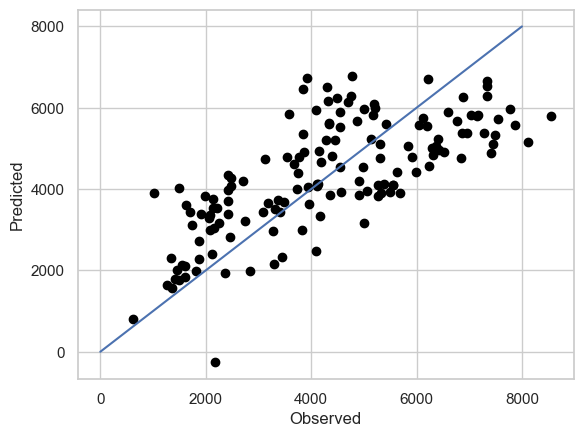

In [27]:
plt.scatter(y_test, y_test_pred,  color='black')
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.plot([0, 8000], [0, 8000])
plt.show()

We'll use the root mean squared error as a performance metric to compare the observed and predicted bike counts. As the name might suggest, this is the average of the squared difference between obs and pred values.

In [28]:
from sklearn.metrics import root_mean_squared_error
print('Root mean squared error: %.2f'
      % root_mean_squared_error(y_test, y_test_pred))

Root mean squared error: 1316.78


So our prediction error from this model is approximately 1300 bikes per day. Note that your results may vary from this due to differences in random selection and model building. 


Now, we'll see if we can improve on this using a random forest model. Random forests (RFs) were first introduced by Leo Breiman to tackle very complex, noisy radar data. They work by building a series of decision trees that use the features to break the dataset down into small ranges of the outcome. For example, a decision might be that any relative humidity above 80% will have much lower values of bike rentals, or that summer months will have some of the highest counts. Each tree is based on a series of these decisions, which makes it possible to model more complex relationships, for example with these data, a tree might predict low counts at temperatures below 5 degrees, then higher counts between 5 and 20 degrees, and then low counts again. 

RF models build several hundred of these trees based on different subsets of the data, and diifferent subsets of the available features. This may seem counter-intuitive (why would you use less data to build a model?), and each individual tree is considered to be a weak model. But the ensemble of trees that are built is extremely robust to variations in the data that are used. Note that one additional advantage from this is that the RF model can provide a range of predicted outcomes (one per tree), but in practice these are usually averaged to a single value. 

Here we use scikit-learn's `RandomForestRegressor()` method from the ensemble subpackage. Scikit-learn distinguishes between methods for regression (continuous outcomes) and classification (binary or categorical outcomes). As before, we first instantiate, then fit

In [29]:
from sklearn import ensemble
rf = ensemble.RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

Now we can go through the same steps of predicting the outcome and calculating the RMSE:

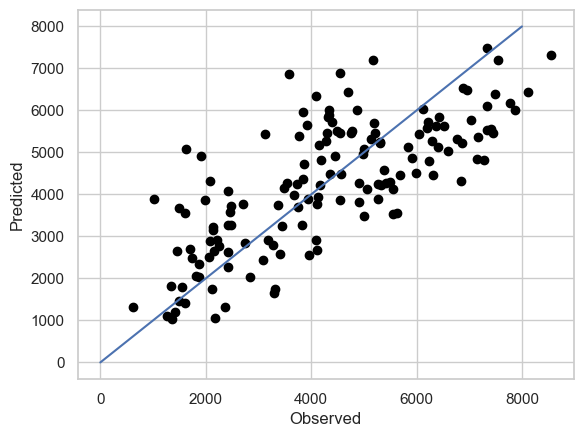

In [30]:
y_test_pred = rf.predict(X_test)
plt.scatter(y_test, y_test_pred,  color='black')
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.plot([0, 8000], [0, 8000])
plt.show()


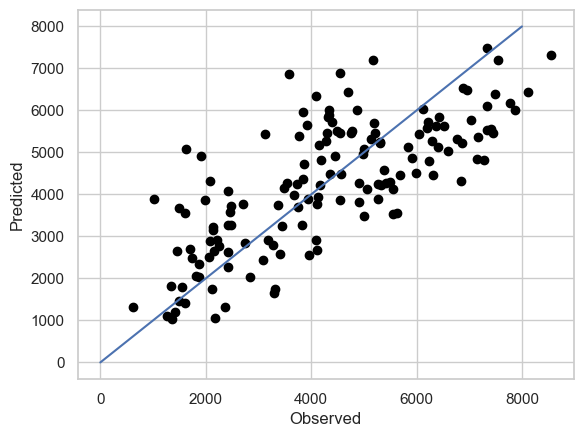

In [31]:
y_test_pred = rf.predict(X_test)
plt.scatter(y_test, y_test_pred,  color='black')
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.plot([0, 8000], [0, 8000])
plt.show()


In [32]:
print('Root mean squared error: %.2f'
      % root_mean_squared_error(y_test, y_test_pred))

Root mean squared error: 1271.08


In [33]:
print('Root mean squared error: %.2f'
      % root_mean_squared_error(y_test, y_test_pred))

Root mean squared error: 1271.08


Although our predictive error is still high, it has dropped substantially from the linear model. 

## Tuning hyperparameters

Most ML algorithms have a set of hyperparameters that control the way in which the algorithm learns. For example, many algorithms use a series of iterations to update their weights, so one hyperparameter might control the number of iterations, and another might control the amount that the weights can be updated in any step. Selecting the optimal value of these, or tuning them, is often an important step in model building and may markedly improve the model skill. 

The set of hyperparameters is specific to each model. A random forest has several, but the most important are generally considered to be a) the number of features used in the decision trees and b) the number of trees that are made. The easiest way to find these to search for the relevant function on scikit-learn's website. The page for a RandomForestRegressor can be found here:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

You can also see these with the `get_params` method:

In [34]:
ensemble.RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


The two arguments we'll need are `max_features` and `n_estimators` respectively. Like most defaults, these are chosen to work reasonably well in most situations, but you can easily change them to see if it improves your model. Here, we'll re-instantiate the random forest with fewer trees (50) and using 2 features in each decision tree split:

In [35]:
rf = ensemble.RandomForestRegressor(max_features=2, n_estimators=50)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=2, n_estimators=50)

In [36]:
y_test_pred = rf.predict(X_test)
print('Root mean squared error: %.2f'
      % root_mean_squared_error(y_test, y_test_pred))

Root mean squared error: 1248.21


In this case, we get a small improvement in the predictive skill compared to the default settings (and this is often the case with random forests - other algorithms may show bigger changes). 

Choosing the best value for the hyperparameters can be a tedious exercise, and often a substantial part of any machine learning project, as testing every possible combination of parameters can become very time consuming. To help with this, most software allows automated tuning of the parameters. Here, the training data are split again into two subsets (one still called training and one called validation). A series of models are built using the new training set with different values for the hyperparameters, and then predicted for the validation set. The hyperparameter values that give the best performance (lowest RMSE in this example) are then considered to be optimal. Scikit-learn has a function (`GridSearchCV`) that will help with all of this. 

Let's start by defining the hyperparameter grid. This is all the values of the hyperparameters we want to test. We'll try values of `n_estimators` from 100 to 500, and `max_features` from 2 to 12:

In [37]:
rf_grid = {'n_estimators':[100, 200, 300, 400, 500],
           'max_features':[2,4,6,8,10,12]}

Next we'll set up the GridSearchCV. As before, this instantiates the function with the algorithm (), the hyperparameter grid and the performance metric (RMSE). We also need a way to split the data for training and validation. Previously, we used a holdout method to get a training and testing set. Here, we'll use a k-fold cross-validation. In this method the data are split $k$ times into a training and validation set and a model is built for each split. The size of each validation set will be $1/k$, so for a 5-fold cross-validation, each validation set is 20% of the data (the argument `cv` sets this). The advantage of this method is that we test each combination of hyperparameters $k$ times, which can provide more stable estimate of which is the best. Note that there are other methods that can be used (e.g. repeated cross-validation, bootstrapping) but are more time-consuming; $k$-fold is often preferred as it is a good balance of speed and robustness.

In [38]:
from sklearn.model_selection import GridSearchCV
rf_tuned = GridSearchCV(ensemble.RandomForestRegressor(), 
                        rf_grid, 
                        scoring='neg_root_mean_squared_error', 
                        cv=5)

Now we have this, we can set up and run the tuning process using the `fit` method. This will take a few seconds to run - it's creating 5 repeats of 5x6 hyperparameter values, so 150 total random forests:

In [39]:
rf_tuned.fit(X_train, y_train)
print(rf_tuned.cv_results_['mean_test_score'])

[-1216.27728365 -1213.03536009 -1204.7156099  -1206.01184196
 -1208.382985   -1199.45924066 -1202.52896606 -1190.39199381
 -1200.10031552 -1197.79908749 -1193.21964185 -1194.69995172
 -1205.41841894 -1204.1817177  -1202.20046358 -1214.78175464
 -1206.88312786 -1205.78988884 -1203.19630073 -1198.18652191
 -1208.62800032 -1208.20182926 -1213.20873468 -1205.6332869
 -1211.35101792 -1214.04750428 -1215.49778669 -1210.77345875
 -1214.55912155 -1211.78762996]


We can get the RMSE for the best performing model:

In [40]:
print(rf_tuned.best_score_)

-1190.3919938096983


Note that you can access the selected model with `rf_tuned.best_estimator_`. We can use this to find the hyperparameter values for the best perfoming model

In [41]:
print('Best max_features:', rf_tuned.best_estimator_.get_params()['max_features'])
print('Best n_estimators:', rf_tuned.best_estimator_.get_params()['n_estimators'])

Best max_features: 4
Best n_estimators: 300


Now's let's test the predictive skill of the selected model (the RMSE printed above is for the validation step). We get another small improvement in the model

In [42]:
y_test_pred = rf_tuned.predict(X_test)
print('Root mean squared error: %.2f'
      % root_mean_squared_error(y_test, y_test_pred))

Root mean squared error: 1207.76


## Exploring the model

Simple regression models such as the one we built above are generally easy to interpret. For example in our model, we found a coefficient of $\approx 150$ for daily temperature. Which we can interpret as the number of bikes rented increases by 150 for each increase in temperature of 1 degree. Interpretation of ML models is much less straightforward for several reasons:

- They do not have a basis to for statistical inference (i.e. you can't get $p$-values)
- They capture non-linearities in the relationship between features and labels
- Often they include complex interactions between features

There are several tools that have been developed to help explore these model. We'll look at a couple of those here.

### Variable importance

First, we'll look at the permutation-based variable importance for this model. Variable importance is a measure of how much worse a model becomes when we randomly shuffle the values of one of the features. The model is used to predict the outcome for some test data twice: once with the original values of the feature and once with randomly shuffled values. If there is a large difference in the skill of the model, this feature is important in controlling the outcome. 

Scikit-learn estimates these automatically during the training stage of the model. You can access them from `model.feature_importances_`:

In [43]:
rf_tuned.best_estimator_.feature_importances_

array([0.42757346, 0.16930518, 0.14308555, 0.00773305, 0.01243782,
       0.03641112, 0.07303333, 0.00712008, 0.00899704, 0.01106315,
       0.00620312, 0.01555745, 0.0121128 , 0.0202622 , 0.00741127,
       0.02159889, 0.02009448])

The importance values are printed following the order of the features in the `X` training data. We can extract and sort these to find the most important features:

In [44]:
importances = rf_tuned.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature 0 temp (0.427573)
2. feature 1 hum (0.169305)
3. feature 2 windspeed (0.143086)
4. feature 6 mnth_JAN (0.073033)
5. feature 5 mnth_FEB (0.036411)
6. feature 15 weathersit_MISTY (0.021599)
7. feature 13 mnth_SEP (0.020262)
8. feature 16 weathersit_RAIN/SNOW/STORM (0.020094)
9. feature 11 mnth_NOV (0.015557)
10. feature 4 mnth_DEC (0.012438)
11. feature 12 mnth_OCT (0.012113)
12. feature 9 mnth_MAR (0.011063)
13. feature 8 mnth_JUN (0.008997)
14. feature 3 mnth_AUG (0.007733)
15. feature 14 holiday_NO HOLIDAY (0.007411)
16. feature 7 mnth_JUL (0.007120)
17. feature 10 mnth_MAY (0.006203)


Or plot these:

<Axes: xlabel='importance', ylabel='feature'>

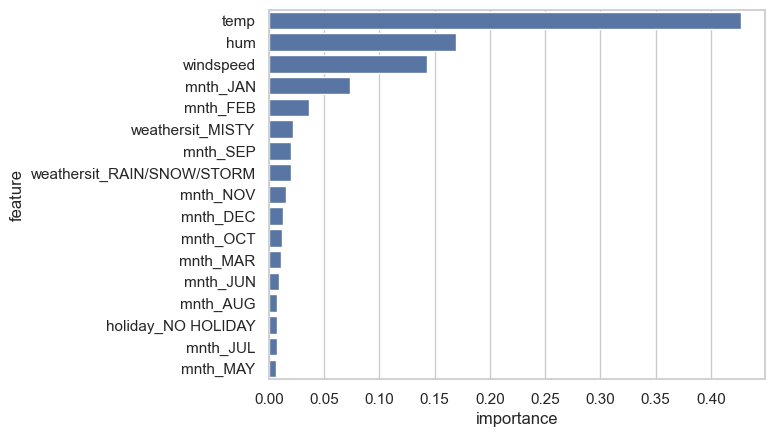

In [45]:
df = pd.DataFrame({'feature': X.columns[indices],
                   'importance': importances[indices]})
#sns.set()
#sns.barplot(y = X.columns, x = importances)
sns.barplot(df, x = 'importance', y = 'feature')

### Partial dependency plots

The variable importance plot shows which of the features are the most useful in predicting bike rentals, but not how these are related. We can look at the form of the relationship between the occurrence of the pine and this feature (and any other one) using a partial dependency (PD) plot. This shows changes in the outcome across the range of some feature (with all other features effectively held constant). 

To get this, we'll use the `PartialDependenceDisplay` function to plot the PD values. As arguments, this requires the model, the set of data used to produce the model and the feature your want to visualize (you can use the column name if the original input was a pandas DataFrame, or the position of the column for a NumPy array). This produces the PD values for temperature (position 0):

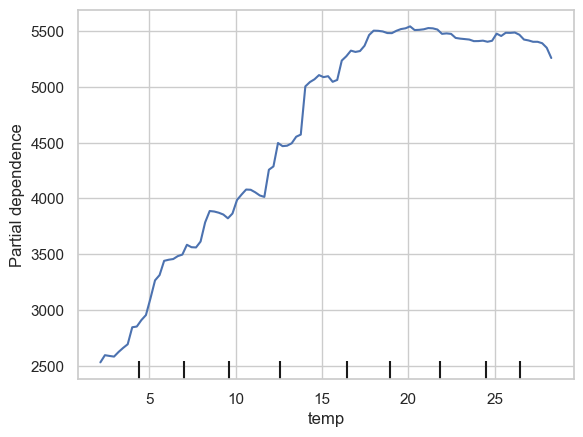

In [46]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(rf_tuned.best_estimator_, X_train, ['temp'])

This illustrates the non-linearity in response. Very few bikes are predicted to be rented below about 2 degC. Rentals then increase in a relative linear fashion to a maximum at about 18 degC, then remain high. Beyond about 25 degC, the rentals start to decline again. 

Try plotting these for other variables (e.g. humidity or wind speed). Partial dependency plots can also be made for multiple variables at the same time, so to show the effect of temperature and windspeed:

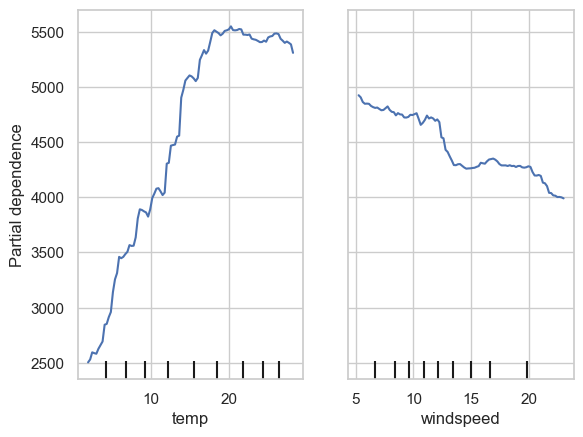

In [47]:
PartialDependenceDisplay.from_estimator(rf_tuned.best_estimator_, X, ['temp', 'windspeed']) 

Or as 2D partial dependency plots to show the combined effect (note how the response to temperature is much flatter at higher wind speeds)

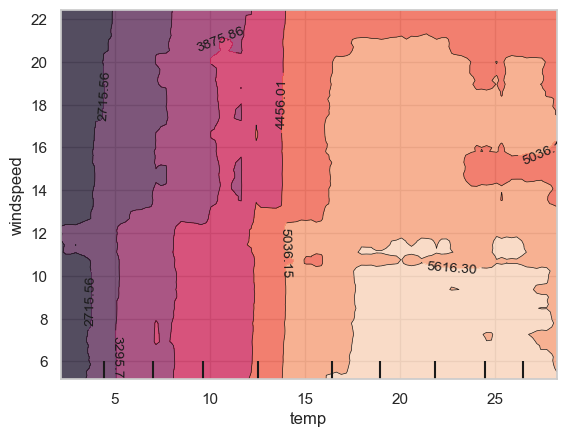

In [48]:
PartialDependenceDisplay.from_estimator(rf_tuned.best_estimator_, X_train, [['temp', 'windspeed']]) 

## Final thoughts

We've been through most of the main steps of a machine learning exercise, including processing, training and testing, and exploring the model. There's quite a lot more that can be done in these steps, but this basic framework works for most projects. This exercise has focused on working with the algorithm - selecting one, tuning it, etc. A very important part of the work is also in selecting the correct variables. 

The models we built all have fairly high error, largely because there is a long-term increasing trend in rentals across the two years. If you have time, try rebuilding and testing a model that includes a feature to capture this (e.g. `yr` or `days_since_2011`), and you'll see a substantial decrease in the RMSE. A thing to note though, is that while this might help in reducing error, it is difficult to see how it could be used in practice. And this illustrates some of the challenge - selecting meaningful features that result in a robust predictive model.  



## Appendix 1: Bike rental dataset

Bike rental dataset from https://christophm.github.io/interpretable-ml-book/bike-data.html:

- `season`: The season, either spring, summer, fall or winter.
- `year`: The year, either 2011 or 2012.
- `mnth`: The month
- `holiday`: Indicator whether the day was a holiday or not.
- `weekday`: Day of week
- `workingday`: Indicator whether the day was a working day or weekend.
- `weathersit`: The weather situation on that day. One of:
  - clear, few clouds, partly cloudy, cloudy
  - mist + clouds, mist + broken clouds, mist + few clouds, mist, light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds
  - heavy rain + ice pallets + thunderstorm + mist, snow + mist
- `temp`: Temperature in degrees Celsius.
- `hum`: Relative humidity in percent (0 to 100).
- `windspeed`: Wind speed in km per hour.
- `count`: Count of bicycles including both casual and registered users. The count is used as the target in the regression task.
- `days_since_2011`: Number of days since the 01.01.2011 (the first day in the dataset). This feature was introduced to take account of the trend over time.